获取 AAPL 的数据...
获取 TSLA 的数据...
获取 ^GSPC 的数据...

因子相关性矩阵:
              Momentum  RelStrength  Volatility  VolumeChange  Reversal
Momentum      1.000000     0.193807   -0.224935     -0.050782 -0.423284
RelStrength   0.193807     1.000000    0.014792     -0.004372 -0.394583
Volatility   -0.224935     0.014792    1.000000      0.058997 -0.030795
VolumeChange -0.050782    -0.004372    0.058997      1.000000  0.183233
Reversal     -0.423284    -0.394583   -0.030795      0.183233  1.000000

相关性低于0.5的因子对:
Momentum 和 RelStrength: 0.1938
Momentum 和 Volatility: -0.2249
Momentum 和 VolumeChange: -0.0508
Momentum 和 Reversal: -0.4233
RelStrength 和 Volatility: 0.0148
RelStrength 和 VolumeChange: -0.0044
RelStrength 和 Reversal: -0.3946
Volatility 和 VolumeChange: 0.0590
Volatility 和 Reversal: -0.0308
VolumeChange 和 Reversal: 0.1832

选择的三个低相关性因子: ['Momentum', 'RelStrength', 'Volatility']

因子夏普比率:
Momentum: -0.4132
RelStrength: 0.9387
Volatility: 0.3336

分析完成，已保存图表。


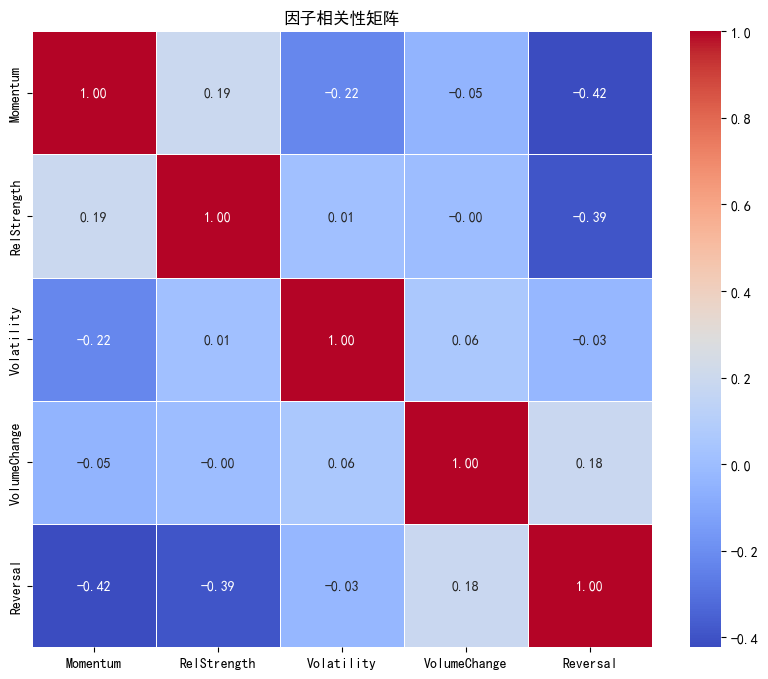

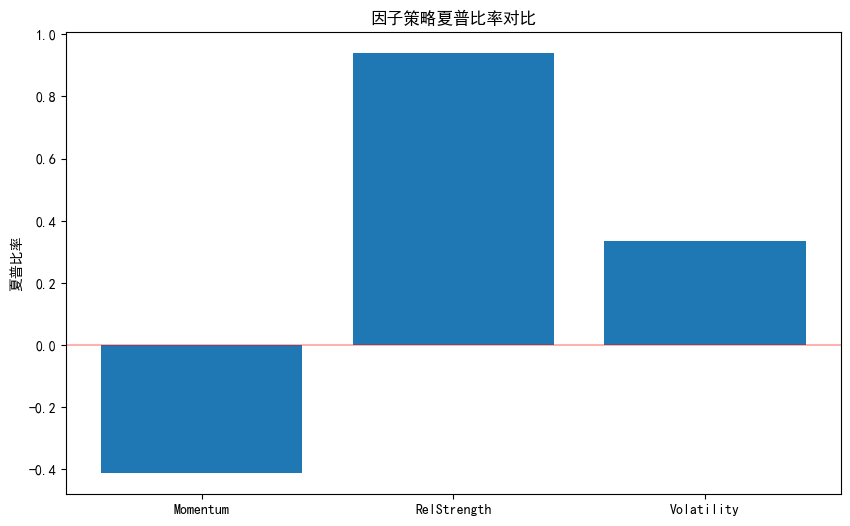

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import mpl
warnings.filterwarnings('ignore')


# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]
# 设置正常显示符号
mpl.rcParams["axes.unicode_minus"] = False

# 使用curl_cffi解决频率限制问题
try:
    from curl_cffi import requests
    print("成功导入curl_cffi")
except ImportError:
    print("请安装curl_cffi: pip install curl_cffi")
    import sys
    sys.exit(1)

# 1. 获取股票数据
def get_stock_data(tickers, period="2y", interval="1d"):
    """
    使用yfinance获取股票数据
    tickers: 股票代码列表
    period: 时间范围，例如"2y"代表2年
    interval: 时间间隔，例如"1d"代表日线数据
    """
    data = {}
    for ticker in tickers:
        print(f"获取 {ticker} 的数据...")
        stock = yf.Ticker(ticker)
        data[ticker] = stock.history(period=period, interval=interval)
    
    return data

# 2. 计算因子
def calculate_factors(stock_data, benchmark_ticker="^GSPC"):
    """
    计算多个因子
    stock_data: 股票数据字典
    benchmark_ticker: 基准指数的股票代码，默认为标普500
    """
    factors = {}
    
    # 遍历每个股票
    for ticker, data in stock_data.items():
        if ticker == benchmark_ticker:
            continue
            
        # 计算每日回报率
        data['Return'] = data['Close'].pct_change()
        
        # 计算因子1：动量因子 - 过去20天的回报率
        data['Momentum'] = data['Close'].pct_change(20)
        
        # 计算因子2：相对强度因子 - 股票相对于市场的表现
        benchmark_returns = stock_data[benchmark_ticker]['Close'].pct_change()
        data['RelStrength'] = data['Return'] - benchmark_returns
        
        # 计算因子3：波动率因子 - 过去20天回报率的标准差
        data['Volatility'] = data['Return'].rolling(window=20).std()
        
        # 计算因子4：交易量变化因子
        data['VolumeChange'] = data['Volume'].pct_change(5)
        
        # 计算因子5：价格反转因子
        data['Reversal'] = -data['Close'].pct_change(5)  # 负号使得价格下跌表示可能的反转上涨
        
        # 删除包含NaN的行，主要是因为计算滚动窗口时前面几行会有NaN
        factors[ticker] = data.dropna()
    
    return factors

# 3. 分析因子相关性
def analyze_factor_correlation(factor_data):
    """
    分析不同因子之间的相关性
    factor_data: 包含因子的DataFrame
    """
    factor_columns = ['Momentum', 'RelStrength', 'Volatility', 'VolumeChange', 'Reversal']
    correlation_matrix = factor_data[factor_columns].corr()
    
    # 查找相关性低于0.5的因子对
    low_corr_pairs = []
    for i in range(len(factor_columns)):
        for j in range(i+1, len(factor_columns)):
            factor1 = factor_columns[i]
            factor2 = factor_columns[j]
            corr = correlation_matrix.loc[factor1, factor2]
            if abs(corr) < 0.5:
                low_corr_pairs.append((factor1, factor2, corr))
    
    return correlation_matrix, low_corr_pairs

# 4. 计算因子夏普比率
def calculate_sharpe_ratio(factor_data, factor_name, forward_returns=1, risk_free_rate=0):
    """
    计算因子的夏普比率
    factor_data: 包含因子和回报率的DataFrame
    factor_name: 因子名称
    forward_returns: 向前看几天的回报
    risk_free_rate: 无风险利率
    """
    # 创建因子信号：正值为1，负值为-1
    signal = np.sign(factor_data[factor_name])
    
    # 计算向前看的回报率
    forward_return = factor_data['Return'].shift(-forward_returns)
    
    # 计算策略回报
    strategy_return = signal * forward_return
    
    # 删除NaN值
    strategy_return = strategy_return.dropna()
    
    # 计算平均日回报率和标准差
    mean_return = strategy_return.mean()
    std_return = strategy_return.std()
    
    # 如果标准差为0，返回0
    if std_return == 0:
        return 0
    
    # 计算年化夏普比率（假设一年有252个交易日）
    annual_factor = np.sqrt(252)  
    sharpe_ratio = (mean_return - risk_free_rate) / std_return * annual_factor
    
    return sharpe_ratio

# 主函数
def main():
    # 股票列表：苹果、特斯拉和标普500指数
    tickers = ['AAPL', 'TSLA', '^GSPC']
    
    # 1. 获取股票数据
    stock_data = get_stock_data(tickers)
    
    # 2. 计算因子
    factors = calculate_factors(stock_data)
    
    # 选择一只股票进行分析
    ticker = 'AAPL'
    factor_data = factors[ticker]
    
    # 3. 分析因子相关性
    correlation_matrix, low_corr_pairs = analyze_factor_correlation(factor_data)
    
    print("\n因子相关性矩阵:")
    print(correlation_matrix)
    
    print("\n相关性低于0.5的因子对:")
    for pair in low_corr_pairs:
        print(f"{pair[0]} 和 {pair[1]}: {pair[2]:.4f}")
    
    # 根据相关性结果选择三个相关性低的因子
    if len(low_corr_pairs) >= 3:
        # 从相关性低的因子对中选择三个不同的因子
        selected_factors = set()
        for pair in low_corr_pairs:
            selected_factors.add(pair[0])
            selected_factors.add(pair[1])
            if len(selected_factors) >= 3:
                break
        
        selected_factors = list(selected_factors)[:3]
    else:
        # 如果没有足够的低相关性因子对，就选择所有因子中相关性最低的三个
        selected_factors = ['Momentum', 'RelStrength', 'Volatility']
    
    print(f"\n选择的三个低相关性因子: {selected_factors}")
    
    # 4. 计算每个选定因子的夏普比率
    print("\n因子夏普比率:")
    sharpe_ratios = {}
    for factor in selected_factors:
        sharpe = calculate_sharpe_ratio(factor_data, factor)
        sharpe_ratios[factor] = sharpe
        print(f"{factor}: {sharpe:.4f}")
    
    # 5. 绘制相关性热图
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('因子相关性矩阵')
    plt.savefig('factor_correlation.png')
    
    # 6. 绘制夏普比率对比图
    plt.figure(figsize=(10, 6))
    plt.bar(sharpe_ratios.keys(), sharpe_ratios.values())
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('因子策略夏普比率对比')
    plt.ylabel('夏普比率')
    plt.savefig('factor_sharpe_ratio.png')
    
    print("\n分析完成，已保存图表。")

if __name__ == "__main__":
    main()